In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib import animation
from scipy import integrate
from scipy import fft

In [2]:
## 1 ##
m = 3
alpha = 0
n = 64
beta = 1
D_1 = 0.1
D_2 = D_1
dt = 0.5
L = 20
T_max = 25

x = np.linspace(-L/2,L/2,n+1)[:-1]
y = np.linspace(-L/2,L/2,n+1)[:-1]
k = (2*np.pi/L)*np.concatenate((np.arange(0,n/2,1),np.arange(-n/2,0,1)))
tspan = np.arange(0,T_max+dt,dt)

X, Y = np.meshgrid(x,y)
KX, KY = np.meshgrid(k,k)
K2 = KX**2 + KY**2

A1 = X

u0 = (np.tanh(np.sqrt(X**2+Y**2))-alpha)*np.cos(m*np.angle(X+1j*Y) - np.sqrt(X**2+Y**2))
v0 = (np.tanh(np.sqrt(X**2+Y**2))-alpha)*np.sin(m*np.angle(X+1j*Y) - np.sqrt(X**2+Y**2))

A2 = u0

uhat0_mat = sp.fft.fft2(u0)
vhat0_mat = sp.fft.fft2(v0)

A3 = uhat0_mat.real

uvhat0_flat = np.concatenate((uhat0_mat.flatten('F'), vhat0_mat.flatten('F')))
A4 = uvhat0_flat.imag.reshape(-1,1)

def rd_fft(t,x,beta,D_1,D_2,n,K2):
    uhat = x[:n**2].reshape(n,n).T
    vhat = x[n**2:].reshape(n,n).T
    
    u = sp.fft.ifft2(uhat).real
    v = sp.fft.ifft2(vhat).real
    
    A = u**2 + v**2
    lmbdA = 1 - A
    wA = -beta*A
    
    uhat_next = sp.fft.fft2(lmbdA*u) - sp.fft.fft2(wA*v) - D_1*(K2*uhat)
    vhat_next = sp.fft.fft2(wA*u)  - sp.fft.fft2(lmbdA*v) - D_2*(K2*vhat)
    
    return np.concatenate((uhat_next.flatten('F'), vhat_next.flatten('F')))

sol = sp.integrate.solve_ivp(rd_fft, [0,T_max], uvhat0_flat, 
                            args = (beta,D_1,D_2,n,K2), t_eval = tspan, method = 'RK45')

A5 = sol.y.real
A6 = sol.y.imag
A7 = sol.y[:n**2,int(2/dt)].real.reshape(-1,1)
A8 = sol.y[:n**2,int(2/dt)].real.reshape(n,n).T
A9 = sp.fft.ifft2(sol.y[:n**2,int(2/dt)].reshape(n,n)).T

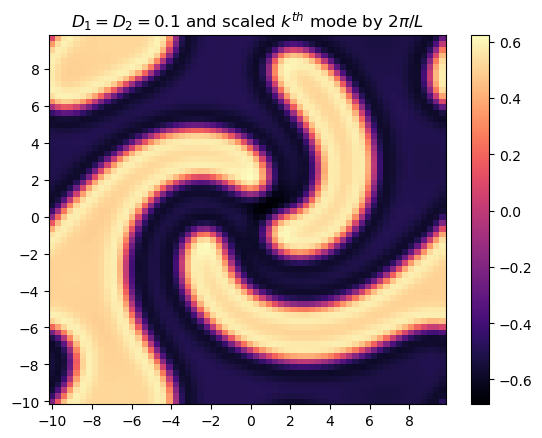

In [3]:
plt.pcolor(X,Y,sp.fft.ifft2(sol.y[:n**2,-1].reshape(n,n)).T.real, cmap = 'magma')
plt.xticks(np.arange(-10,10,2))
plt.yticks(np.arange(-10,10,2))
plt.colorbar()
plt.title('$D_1=D_2=0.1$ and scaled $k^{th}$ mode by $2\pi/L$')
#plt.clim(-1,1)
plt.show()

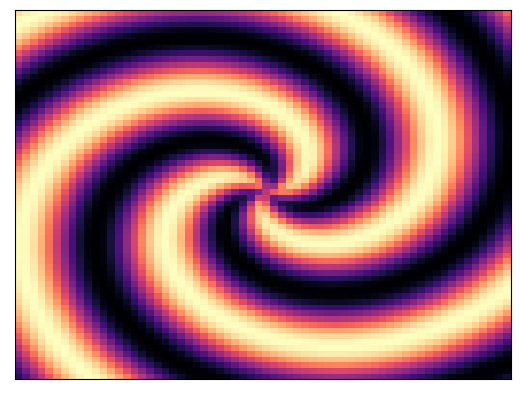

In [4]:
fig, ax = plt.subplots(1)
im = ax.pcolor(X,Y,sp.fft.ifft2(sol.y[:n**2,0].reshape(n,n)).T.real, cmap = 'magma')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

def update(frame):
    im.set_array(sp.fft.ifft2(sol.y[:n**2,frame].reshape(n,n)).T.real.ravel())
    return im,

ani = animation.FuncAnimation(fig, update, frames = range(len(tspan)-1), interval = 1, blit = True)

writergif = animation.PillowWriter(fps = 24)
ani.save('rd_fft.gif', writer = writergif)

In [7]:
## 2 ##
def cheb(N):
    # N is the number of points in the interior.
    if N==0:
        D = 0
        x = 1
        return D, x
    vals = np.linspace(0, N, N+1)
    x = np.cos(np.pi*vals/N)
    x = x.reshape(-1, 1)
    c = np.ones(N-1)
    c = np.pad(c, (1,), constant_values = 2)
    c *= (-1)**vals
    c = c.reshape(-1, 1)
    X = np.tile(x, (1, N+1))
    dX = X-X.T                  
    D  = (c*(1/c.T))/(dX+(np.eye(N+1)))       #off-diagonal entries
    D  = D - np.diag(sum(D.T))                #diagonal entries

    return D, x

m = 2
n = 30
alpha = 1

cD, x = cheb(n)
cD2 = 4*(cD@cD)[1:-1,1:-1]/L**2

lap = np.kron(cD2,np.eye(len(cD2))) + np.kron(np.eye(len(cD2)),cD2)
A10 = lap

x2 = x[1:-1]*L/2

X,Y = np.meshgrid(x2,x2)

A11 = Y

u0 = (np.tanh(np.sqrt(X**2+Y**2))-alpha)*np.cos(m*np.angle(X+1j*Y) - np.sqrt(X**2+Y**2))
v0 = (np.tanh(np.sqrt(X**2+Y**2))-alpha)*np.sin(m*np.angle(X+1j*Y) - np.sqrt(X**2+Y**2))

A12 = v0
uv0_flat = np.concatenate((u0.flatten('F'), v0.flatten('F')))

A13 = uv0_flat.reshape(-1,1)

def rd_cheb(t,x,beta,D_1,D_2,lap,n):
    n = n-1
    u = x[:n**2]
    v = x[n**2:]
    
    A = u**2 + v**2
    lmbdA = 1 - A
    wA = -beta*A
    
    u_next = lmbdA*u - wA*v + D_1*lap@x[:n**2]
    v_next = wA*u - lmbdA*v + D_2*lap@x[n**2:]
    return np.concatenate((u_next, v_next))

sol = sp.integrate.solve_ivp(rd_cheb, [0,T_max], uv0_flat, args = (beta, D_1, D_2, lap, n), t_eval = tspan, method = 'RK45')

A14 = sol.y.T

A15 = sol.y[(n-1)**2:,int(2/dt)].reshape(-1,1)

A16 = np.pad(sol.y[(n-1)**2:,int(2/dt)].reshape(n-1,n-1).T, 1, mode = 'constant')

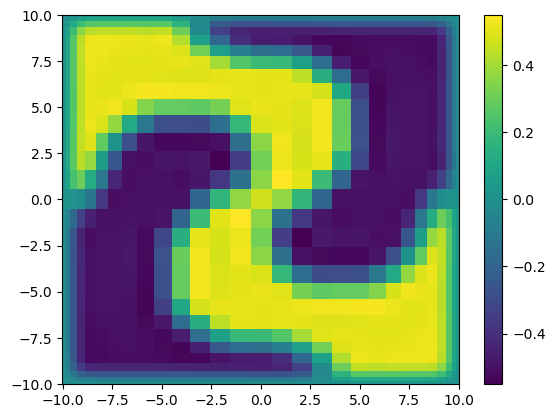

In [16]:
X_plt, Y_plt = np.meshgrid(x*L/2,x*L/2)
plt.pcolor(X_plt, Y_plt, np.pad(sol.y[(n-1)**2:,-1].reshape(n-1,n-1).T, 1, mode = 'constant'))
plt.colorbar()
plt.show()

In [34]:
sol.y[(n-1)**2:,int(2/dt)].reshape(-1,1)

array([[-1.35078430e-05],
       [ 2.67961645e-06],
       [-4.85482821e-07],
       [ 1.02226848e-07],
       [-3.37328000e-08],
       [ 1.47985216e-08],
       [-1.57272942e-08],
       [ 2.45094364e-08],
       [-3.96051976e-08],
       [ 6.31613172e-08],
       [-9.30974913e-08],
       [ 2.63937043e-07],
       [ 2.39445657e-06],
       [ 3.47127483e-05],
       [ 2.39791789e-05],
       [ 2.99822508e-05],
       [ 1.97929741e-06],
       [ 2.72808618e-07],
       [-1.05722463e-07],
       [ 6.85583220e-08],
       [-4.31027235e-08],
       [ 2.69124894e-08],
       [-1.75290214e-08],
       [ 1.62332953e-08],
       [-3.49092396e-08],
       [ 1.03172640e-07],
       [-4.85931773e-07],
       [ 2.67718508e-06],
       [-1.34937053e-05],
       [ 2.67971733e-06],
       [-5.29421996e-07],
       [ 7.97687116e-08],
       [-8.06062880e-09],
       [-9.47376382e-09],
       [ 1.57867719e-08],
       [-2.01776630e-08],
       [ 2.51462762e-08],
       [-3.24508155e-08],
       [ 4.4